In [ ]:
# Google Colaboratory에서 작성하였습니다.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np

https://archive.ics.uci.edu/ml/datasets/Heart+Disease 에서 dataset을 불러온다.
processed.cleveland.data 이외의 dataset은 결측치가 많은 등 사용에 어려움이 있음을 고려하여 cleveland dataset만 쓰기로 결정하였다.

Note. processed.hungarian.data, processed.va.data, processed.switzerland.data는 10, 11, 12번째 column의 결측치 비율이 80% 이상이라 column 자체를 제거하여야 하고, 20% 이상의 결측치 비율을 가지는 column도 꽤 있다. 이때 column 삭제와 20% 이상의 결측치 비율을 가지는 column 여러 개에 regression이나 imputation을 모두 적용하면 그 dataset이 사용에 적합하다고 보기 어렵다고 생각한다.

In [ ]:
cle_data = pd.read_csv('./processed.cleveland.data')
cle_data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
cle_data
# 각 column의 index를 dataframe에 넣는다.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


일반적으로, 결측치의 비율에 따라 다른 방법으로 결측치를 처리한다.
- 10% 미만:
삭제 또는 대치
- 10% - 50%:
regression 이나 model based imputation 활용
- 50% 이상:
해당 column 제거

In [ ]:
sum = 0
n = len(cle_data.index)
d = len(cle_data.columns)

a = 0
b = 0

arr11 = []
arr12 = []

for i in range(n):
    for j in range(d):
        if(cle_data.iloc[i, j] == '?'):
            print((i, j))
            sum = sum + 1
            if j == 11:
                a = a + 1
                arr11.append(i)
            if j == 12:
                b = b + 1
                arr12.append(i)

            cle_data.iloc[i, j] = 'NaN'
            
percentage = (sum/(n*d)) * 100
print(percentage)
print((a/n)*100)
print((b/n)*100)

(86, 12)
(165, 11)
(191, 11)
(265, 12)
(286, 11)
(301, 11)
0.14191106906338694
1.3245033112582782
0.6622516556291391


이 dataset의 결측치 비율은 모두 10%보다 작기에 '대치' 방식을 사용하기로 결정했다.

In [ ]:
for i in range(n):
    for j in range(d-1):
        cle_data.iloc[:, j] = cle_data.iloc[:, j].astype(float)
        # 연산을 하기 위해 str 형을 모두 float으로 변환

np.mean(cle_data, axis = 0) # column별 평균값

age          54.410596
sex           0.678808
cp            3.165563
trestbps    131.645695
chol        246.738411
fbs           0.145695
restecg       0.986755
thalach     149.605960
exang         0.327815
oldpeak       1.035430
slope         1.596026
ca            0.674497
thal          4.730000
num           0.940397
dtype: float64

In [ ]:
cle_data.median(skipna=True) # column별 중앙값

age          55.5
sex           1.0
cp            3.0
trestbps    130.0
chol        241.5
fbs           0.0
restecg       0.5
thalach     153.0
exang         0.0
oldpeak       0.8
slope         2.0
ca            0.0
thal          3.0
num           0.0
dtype: float64

In [ ]:
from scipy.stats import mode
mode(cle_data) # column별 최빈값

ModeResult(mode=array([[ 58.,   1.,   4., 120., 197.,   0.,   0., 162.,   0.,   0.,   1.,
          0.,   3.,   0.]]), count=array([[ 19, 205, 144,  37,   6, 258, 151,  11, 203,  99, 142, 175, 166,
        163]]))

In [ ]:
for k in range(len(arr11)):
    cle_data.iloc[arr11[k], 11] = 0.0
    # 11번째 column은 중앙값, 최빈값은 0.0이고,
    #평균은 0.0에 가깝기에 0.0으로 대치한다.
for k in range(len(arr12)):
    cle_data.iloc[arr12[k], 12] = 3.0
    # 12번째 column은 중앙값, 최빈값은 3.0이고 평균도 3.0보다는 크지만 가까운 
    # 편이기에 3.0으로 대치한다.

In [ ]:
cle_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [ ]:
cle_data.isnull().any() # Sanity check

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
num         False
dtype: bool

In [ ]:
sum = 0
n = len(cle_data.index)
d = len(cle_data.columns)

for i in range(n):
    for j in range(d):
        if(cle_data.iloc[i, j] == '?'):
            sum = sum + 1
print(sum)
# 전처리 결과, '?' 값을 가지는 entry, 즉 결측치가 없음을 확인하였다.

0


경험적으로, 302x14 사이즈의 dataset만으로는 heart disease의 severity(num: 0 to 4)를 예측하기 어려울 것으로 판단된다. 따라서 binary data(heart disease diagnosis 유무)로 바꾸었다. (0: heart disease X, 1: heart disease O)

In [ ]:
for k in range(len(cle_data.index)):
    if cle_data.iloc[k, 13] > 1:
        cle_data.iloc[k, 13] = 1

cle_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [ ]:
np.mean(cle_data['num']) # Sanity check: num의 평균이 0.5에 가까워졌다.

0.4602649006622517

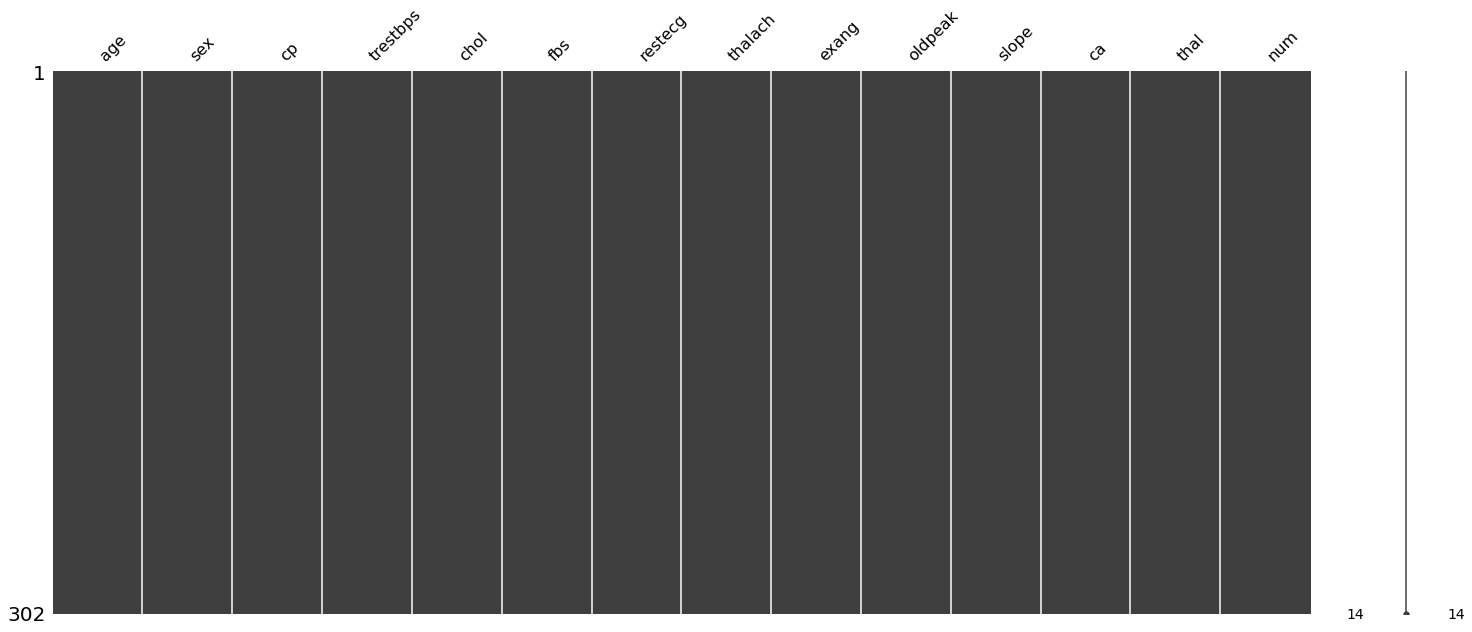

In [ ]:
!pip install missingno -q
import missingno as msno

msno.matrix(cle_data); # null 값이 있는지 마지막으로 확인해본다.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     |████████████████████████████████| 25.9 MB 119 kB/s 
     |████████████████████████████████| 10.1 MB 76 kB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 102 kB 11.4 MB/s 
     |████████████████████████████████| 675 kB 56.2 MB/s 
     |████████████████████████████████| 4.7 MB 58.7 MB/s 
     |████████████████████████████████| 62 kB 848 kB/s 
     |████████████████████████████████| 812 kB 61.0 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261287 sha256=a19cfd598a29bf1cabef7a42fd4c9d28863078bc6ed6ff9ca6d71a136981daa0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2ay8w09_/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0dfeaa2c9eebb483a809bcfbf953d9fd03c48ec4ad756257de4c99388ac2bbf2
  Stored in directory: /root

In [ ]:
import pandas_profiling as pp
pp.ProfileReport(cle_data)
# dataset의 전반적인 평가 지표를 출력해보았다.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

변수 간 상관관계(corr)를 나타내는 heatmap을 그려서 핵심 feature를 찾아낼 수 있는지, plot을 그리기에 적합한 상관관계를 가진 feature는 무엇인지 알아본다.

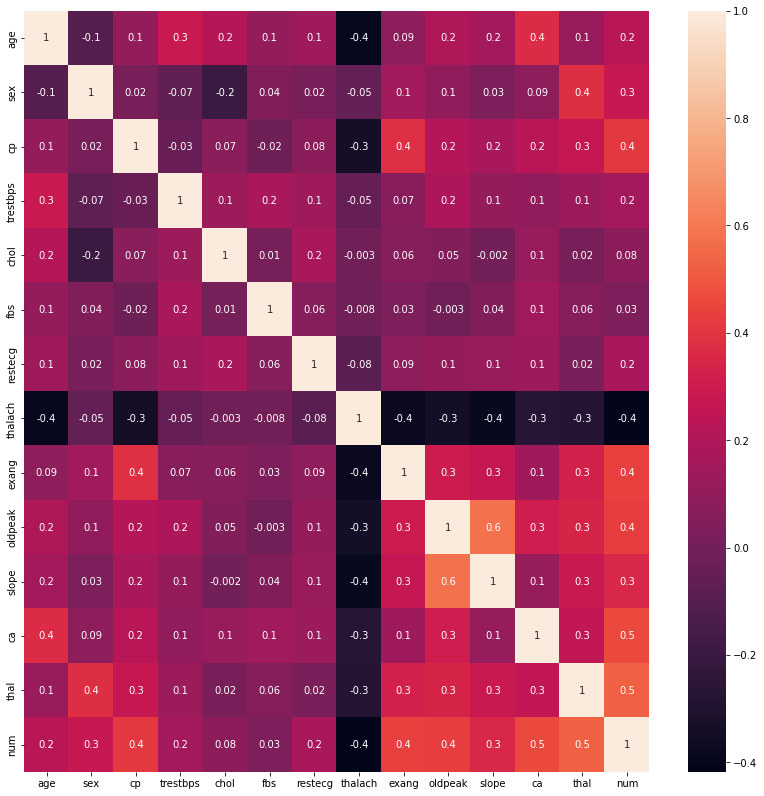

In [ ]:
plt.figure(figsize = (14, 14))
sns.heatmap(cle_data.corr(), annot = True, fmt = '.1g')

경험적으로, 적어도 0.7, 0.8 이상의 상관도가 되어야 이를 유의미하게 사용할 수 있다. 따라서 위의 heatmap에서 일부 feature를 선택한 후 소수의 principal components(eigenvectors)로 PCA를 적용한 후 시각화하고 모델링에 사용하여 차원 축소를 한 데이터와 원본 데이터를 비교하는 모델링을 하기는 어렵다.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
pca_scaler = StandardScaler()
pca_scaled = pca_scaler.fit_transform(cle_data.drop(['num'], axis = 1))

In [ ]:
pca = PCA(n_components = 0.95)
df_pca = pca.fit_transform(pca_scaled)

In [ ]:
pca.explained_variance_ratio_ # Sanity check

array([0.23777667, 0.12321429, 0.09385718, 0.0835666 , 0.0760388 ,
       0.06855968, 0.06651988, 0.06002744, 0.0525316 , 0.04350555,
       0.0353763 , 0.03155869])

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9725326856610865

In [ ]:
df_pca.shape

(302, 12)

전체 feature에 대해 PCA를 적용했을 때 95% 이상의 설명력을 가지려면 principal components(eigenvectors)가 12개 있어야 한다. 따라서 이 dataset의 경우 유의미하게 차원 축소를 하기 어려우므로 PCA 사용에는 어려움이 있을 것으로 생각한다.

#Data Visualization

우선, 전체 histogram을 그려보았다.

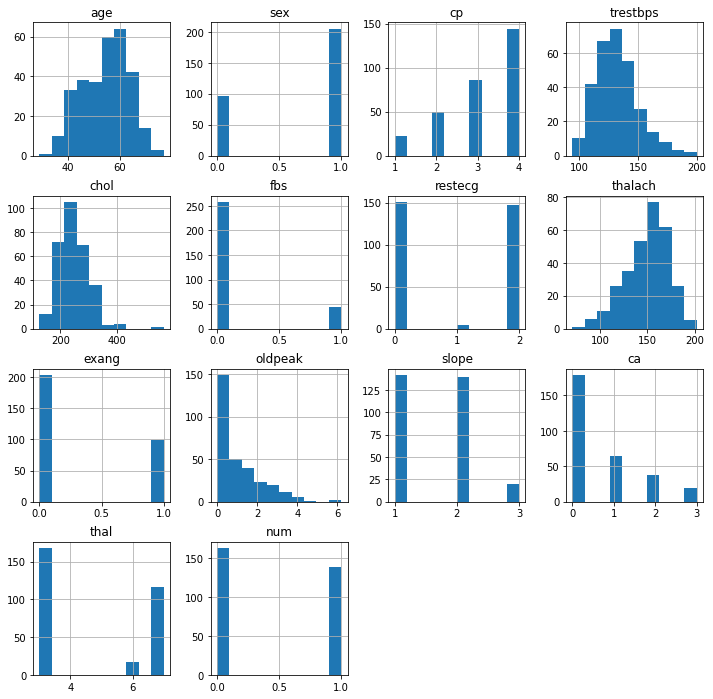

In [ ]:
cle_data.hist(figsize = (12, 12))
plt.show()

Data Analysis 파트의 heatmap 결과를 이용하여 num, 즉 target 값과 0.2 이상의 상관도를 
보이는 feature를 선택한 후 시각화하겠다.

1. age - num

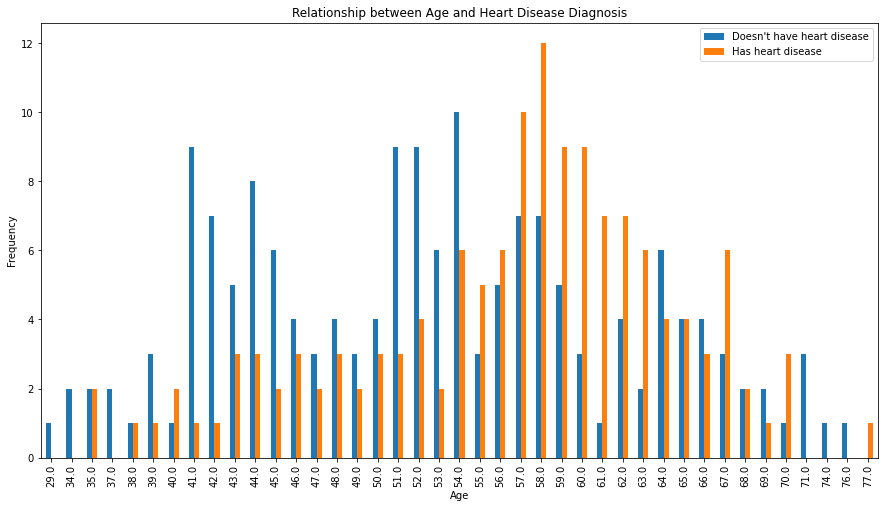

In [ ]:
pd.crosstab(cle_data.age,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between Age and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

2. sex - num

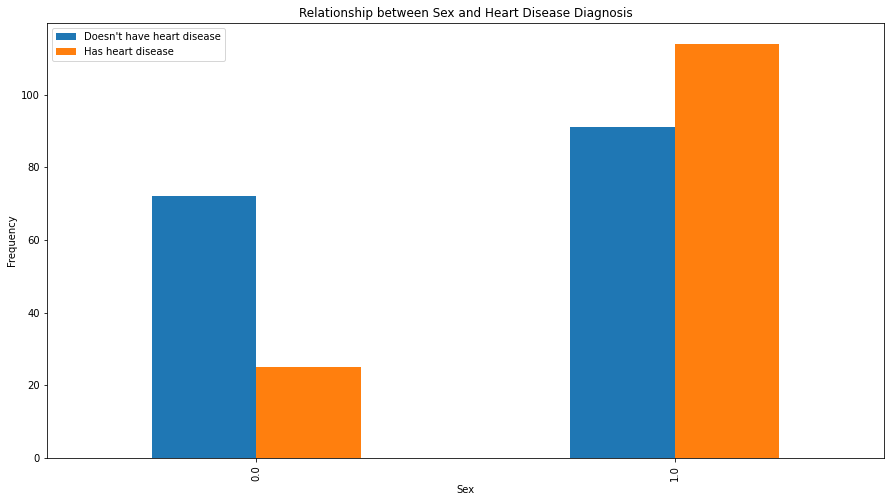

In [ ]:
pd.crosstab(cle_data.sex,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between Sex and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.show()

3. cp - num

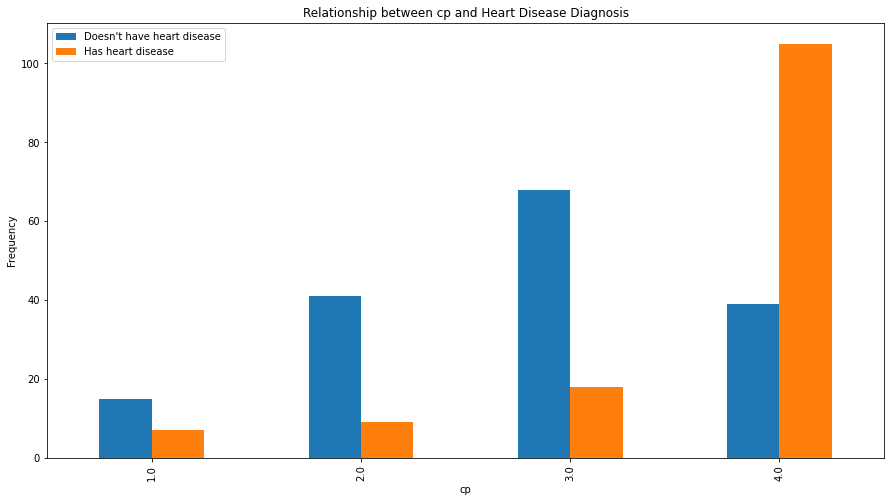

In [ ]:
pd.crosstab(cle_data.cp,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between cp and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('cp')
plt.ylabel('Frequency')
plt.show()

 4. trestbps - num

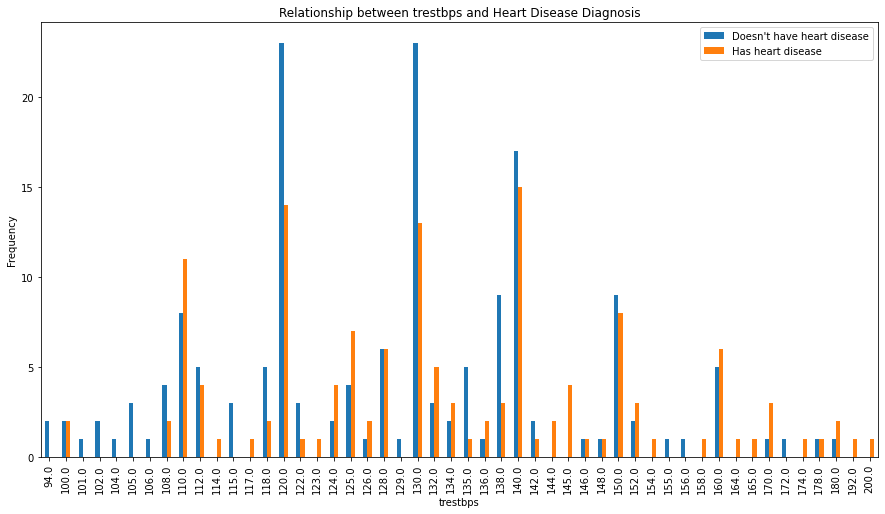

In [ ]:
pd.crosstab(cle_data.trestbps,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between trestbps and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('trestbps')
plt.ylabel('Frequency')
plt.show()

5. restecg - num

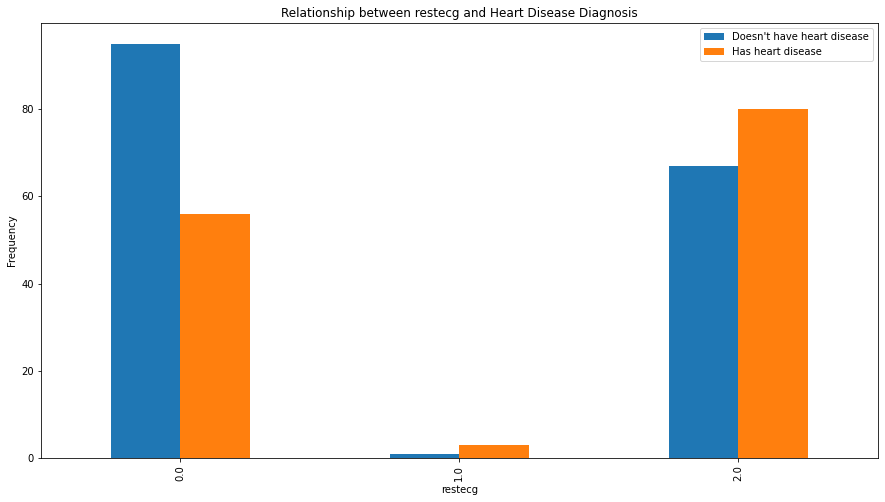

In [ ]:
pd.crosstab(cle_data.restecg,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between restecg and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('restecg')
plt.ylabel('Frequency')
plt.show()

6. exang - num

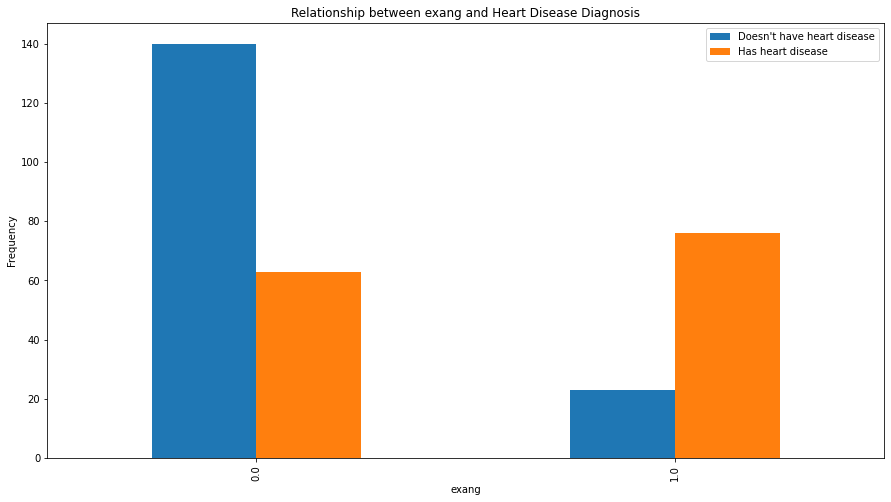

In [ ]:
pd.crosstab(cle_data.exang,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between exang and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('exang')
plt.ylabel('Frequency')
plt.show()

7. oldpeak - num

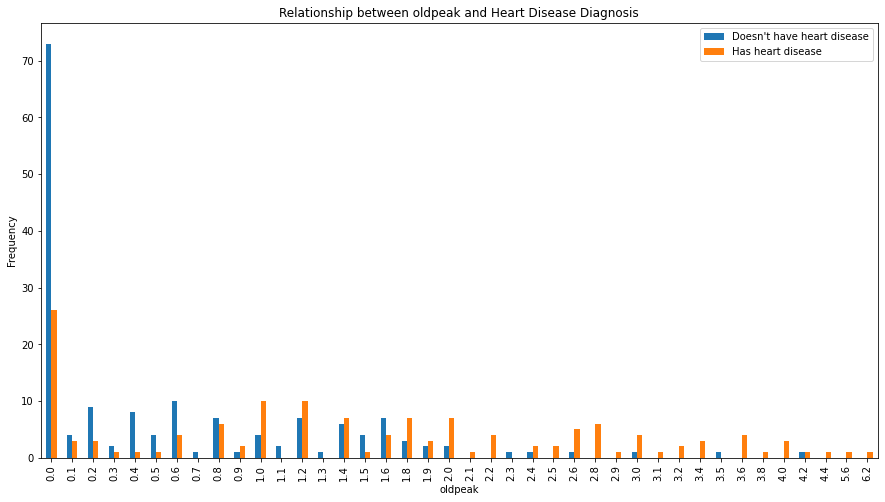

In [ ]:
pd.crosstab(cle_data.oldpeak,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between oldpeak and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('oldpeak')
plt.ylabel('Frequency')
plt.show()

8. slope - num

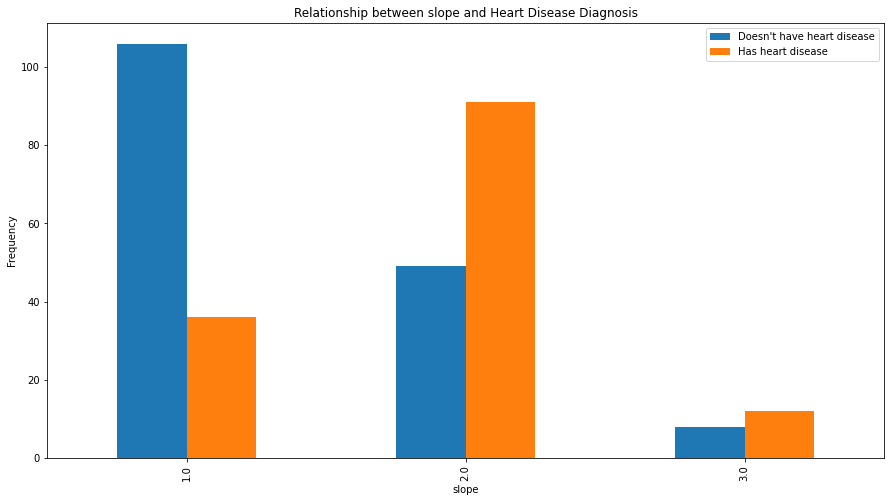

In [ ]:
pd.crosstab(cle_data.slope,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between slope and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('slope')
plt.ylabel('Frequency')
plt.show()

9. ca - num

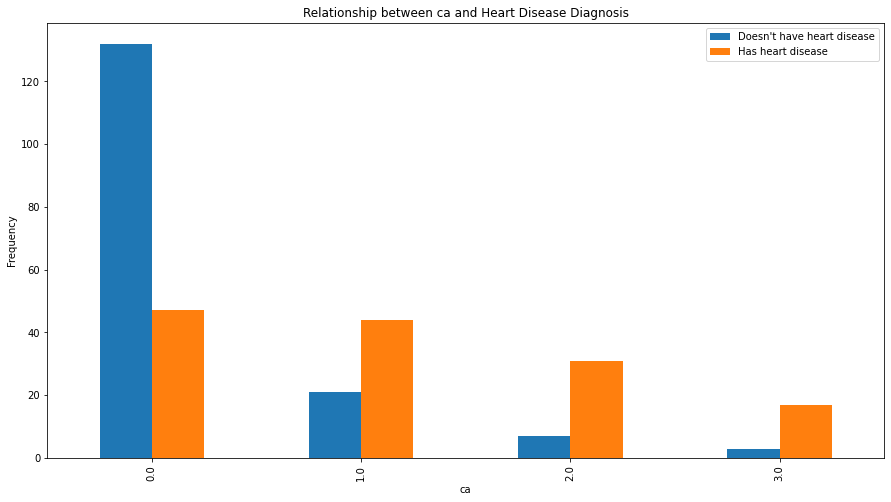

In [ ]:
pd.crosstab(cle_data.ca,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between ca and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('ca')
plt.ylabel('Frequency')
plt.show()

10. thal - num

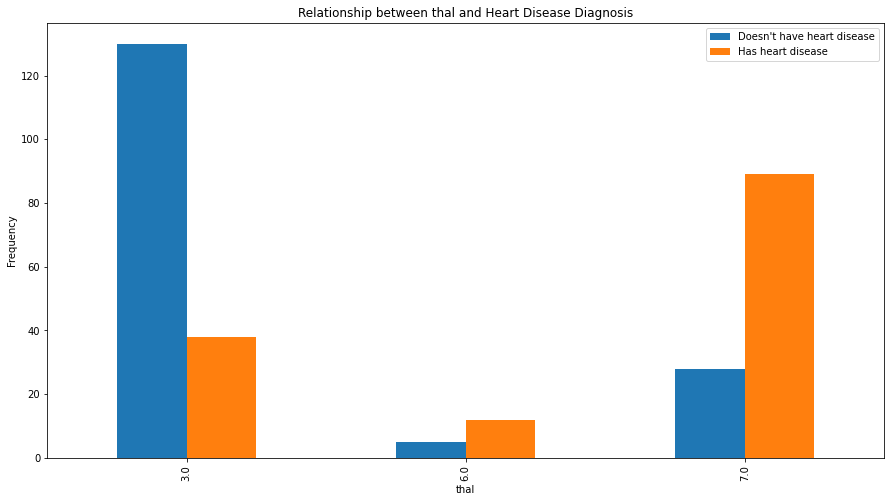

In [ ]:
pd.crosstab(cle_data.thal,cle_data.num).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between thal and Heart Disease Diagnosis')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('thal')
plt.ylabel('Frequency')
plt.show()

* 추가적으로, heatmap에서 slope와 oldpeak이 0.6의 상관도로 이 dataset의 feature 간 상관도 중 가장 높은 값을 가짐을 알 수 있었다.

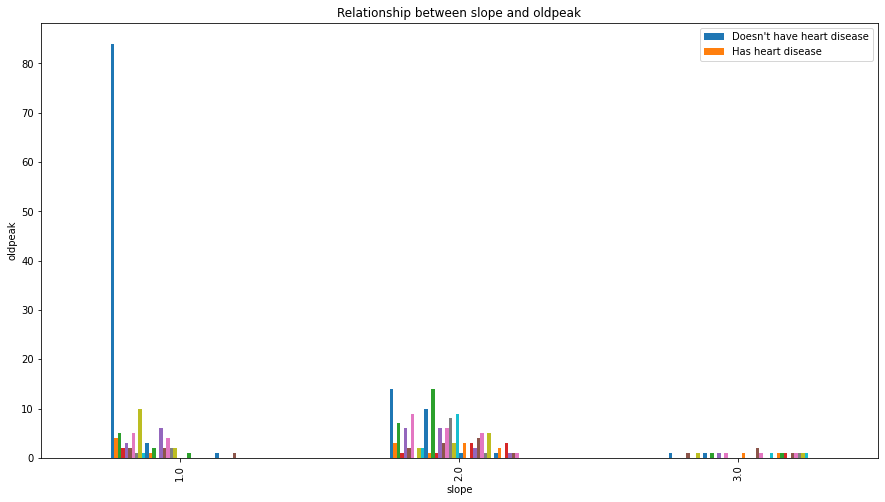

In [ ]:
pd.crosstab(cle_data.slope,cle_data.oldpeak).plot(kind="bar",figsize=(15,8))
plt.title('Relationship between slope and oldpeak')
plt.legend(["Doesn't have heart disease", "Has heart disease"])
plt.xlabel('slope')
plt.ylabel('oldpeak')
plt.show()

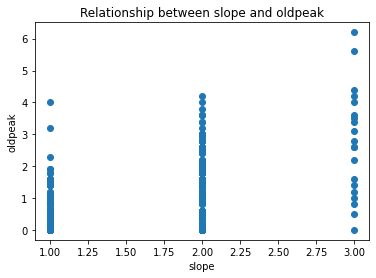

In [ ]:
plt.scatter(cle_data.slope,cle_data.oldpeak)
plt.title('Relationship between slope and oldpeak')
plt.xlabel('slope')
plt.ylabel('oldpeak')
plt.show()

#Modeling

In [ ]:
X = np.array(cle_data.drop(['num'], axis = 1))
y = np.array(cle_data['num'])
# data와 label(target)을 나눈다. 종속변수(1개)는 cle_data['num'], 즉 heart disease diagnosis로 설정하였다.

위에서 histogram을 그린 결과, 큰 이상치는 없는 것으로 보인다. 따라서 StandardScaler를 사용할 때 균형잡힌 척도를 부여하였다고 할 수 있다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled_X = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_scaled_X, y, random_state = 256, test_size = 0.2)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=128, test_size = 0.3)

dataset을 train, validation, test로 나눈다.
train은 0.8x0.7=0.56, validation은 0.8x0.3=0.24, test는 0.2 의 비율을 가지게 설정하였다.

- Building a model

여러 개의 model을 구성하여 train dataset으로 훈련시킨 후, validation dataset으로 검증하고 나머지 test dataset으로 앞으로의 모델 성능을 예측해본다. validation dataset으로 검증했을 때의 평가 지표는 accuracy_score와 classification_report를 활용해 출력하겠다.

1. Linear Regression and Logistic Regression

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
# linear regression은 단순하여 훈련이 잘 안될 수도 있지만, 가장 고전적이고 기본적인 모델이기에 우선 시도해보았다.

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lin_pred = lin_model.predict(X_valid)

In [ ]:
log_pred = log_model.predict(X_valid)

In [ ]:
lin_model.score(X_valid, y_valid)

0.4713617604741127

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(y_valid, log_pred)

0.821917808219178

In [ ]:
print(classification_report(y_valid, log_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        42
           1       0.82      0.74      0.78        31

    accuracy                           0.82        73
   macro avg       0.82      0.81      0.82        73
weighted avg       0.82      0.82      0.82        73



2. K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2)
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_pred = KNN.predict(X_valid)
accuracy_score(y_valid, knn_pred)

0.821917808219178

In [ ]:
print(classification_report(y_valid, knn_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        42
           1       0.85      0.71      0.77        31

    accuracy                           0.82        73
   macro avg       0.83      0.81      0.81        73
weighted avg       0.82      0.82      0.82        73



In [ ]:
# 이웃 개수 parameter를 바꾸어 보았다.
# 실행 결과, n_neighbors=3 값이 가장 좋은 performance를 보인다.
from sklearn.neighbors import KNeighborsClassifier
KNN_2 = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p=2)
KNN_2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn_pred_2 = KNN_2.predict(X_valid)
accuracy_score(y_valid, knn_pred_2)

0.8493150684931506

In [ ]:
print(classification_report(y_valid, knn_pred_2))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        42
           1       0.88      0.74      0.81        31

    accuracy                           0.85        73
   macro avg       0.86      0.84      0.84        73
weighted avg       0.85      0.85      0.85        73



3. SVM

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc_pred = svc.predict(X_valid)
accuracy_score(y_valid, svc_pred)

0.8356164383561644

In [ ]:
print(classification_report(y_valid, svc_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        42
           1       0.88      0.71      0.79        31

    accuracy                           0.84        73
   macro avg       0.85      0.82      0.83        73
weighted avg       0.84      0.84      0.83        73



In [ ]:
# kernel 종류 변경: rbf kernel을 사용해보았다.
from sklearn.svm import SVC
svc_rbf = SVC(kernel = 'rbf')
svc_rbf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc_pred_rbf = svc_rbf.predict(X_valid)
accuracy_score(y_valid, svc_pred_rbf)

0.8493150684931506

In [ ]:
print(classification_report(y_valid, svc_pred_rbf))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        42
           1       0.88      0.74      0.81        31

    accuracy                           0.85        73
   macro avg       0.86      0.84      0.84        73
weighted avg       0.85      0.85      0.85        73



In [ ]:
# kernel 종류 변경: polynomial kernel을 사용해보았다.
from sklearn.svm import SVC
svc_poly = SVC(kernel = 'poly')
svc_poly.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc_pred_poly = svc_poly.predict(X_valid)
accuracy_score(y_valid, svc_pred_poly)

0.8082191780821918

In [ ]:
print(classification_report(y_valid, svc_pred_poly))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        42
           1       0.81      0.71      0.76        31

    accuracy                           0.81        73
   macro avg       0.81      0.80      0.80        73
weighted avg       0.81      0.81      0.81        73



4. Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
dtc_pred = dtc.predict(X_valid)
accuracy_score(y_valid, dtc_pred)

0.8082191780821918

In [ ]:
print(classification_report(y_valid, dtc_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        42
           1       0.76      0.81      0.78        31

    accuracy                           0.81        73
   macro avg       0.80      0.81      0.81        73
weighted avg       0.81      0.81      0.81        73



5. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc_pred = rfc.predict(X_valid)
accuracy_score(y_valid, rfc_pred)

0.8356164383561644

In [ ]:
print(classification_report(y_valid, rfc_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        42
           1       0.85      0.74      0.79        31

    accuracy                           0.84        73
   macro avg       0.84      0.82      0.83        73
weighted avg       0.84      0.84      0.83        73



6. XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_pred = xgb_model.predict(X_valid)
accuracy_score(y_valid, xgb_pred)

0.8082191780821918

In [ ]:
print(classification_report(y_valid, xgb_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        42
           1       0.77      0.77      0.77        31

    accuracy                           0.81        73
   macro avg       0.80      0.80      0.80        73
weighted avg       0.81      0.81      0.81        73



7. Neural Network

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
Y_train = to_categorical(y_train, num_classes = None)
Y_valid = to_categorical(y_valid, num_classes = None)
Y_test = to_categorical(y_test, num_classes = None)
Y_train.shape # Sanity check

(168, 2)

In [ ]:
import tensorflow as tf

learning_rate = 0.001 # 보편적으로 사용하는 lr 값을 적용해보았다.

def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 16, input_dim = 13, kernel_initializer = 'uniform', activation = 'relu'))
    # input_dim은 X_train의 column 개수인 13개가 되어야 한다.
    model.add(tf.keras.layers.Dropout(0.3)) # 과적합을 방지하기 위해 dropout을 적용해준다.
    model.add(tf.keras.layers.Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    # 1, 2번째 dense 층은 activation 함수로 relu, 마지막은 categorical classification 이기에 softmax를 사용했다.
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units = 2, kernel_initializer = 'uniform', activation = 'softmax'))
    # 마지막 dense 층은 categorical data이기 때문에 units = 2로 설정해준다.
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate), metrics = ['accuracy'])
    # 보편적으로 가장 성능이 좋다고 알려진 adam optimizer를 사용했고, categorical classification이기에 categorical_crossentropy로 loss를 측정한다.
    return model

model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                224       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________


경험적으로, batch_size는 2^n 꼴 중에서도 32, 64가 잘 작동한다.

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), epochs = 100, batch_size = 32)

Epoch 1/100
6/6 [==============================] - 1s 40ms/step - loss: 0.6931 - accuracy: 0.4643 - val_loss: 0.6932 - val_accuracy: 0.4247
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5060 - val_loss: 0.6927 - val_accuracy: 0.4247
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5476 - val_loss: 0.6919 - val_accuracy: 0.7534
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.7321 - val_loss: 0.6909 - val_accuracy: 0.7534
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6905 - val_loss: 0.6896 - val_accuracy: 0.6712
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.6369 - val_loss: 0.6872 - val_accuracy: 0.7123
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.6845 - val_loss: 0.6835 - val_accuracy: 0.7671
Epoch 8/100
6/6 [=========

여러 번 실행해본 결과, heart disease dataset에서는 batch_size = 32가 64보다 더 적합하게 나타났다. epoch 값은 overfitting 방지를 위해 여러 값으로 실행해본 후 결정하였다.

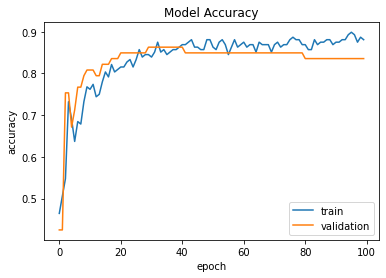

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

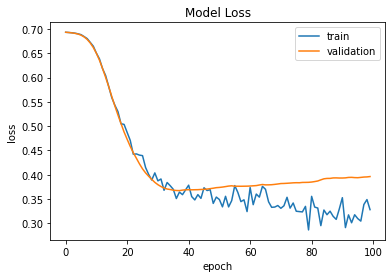

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
dnn_pred = np.argmax(model.predict(X_valid), axis=1)
print(accuracy_score(y_valid, dnn_pred))

0.8356164383561644


In [ ]:
print(classification_report(y_valid, dnn_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        42
           1       0.88      0.71      0.79        31

    accuracy                           0.84        73
   macro avg       0.85      0.82      0.83        73
weighted avg       0.84      0.84      0.83        73



#TEST data

앞으로의 모델 성능을 test dataset을 사용하여 예측할 것이다. classification_report 함수로 평가 지표(precision, recall, f1-score, support)를 출력하고, roc curve를 시각화한 후 auc값도 출력하겠다.

In [ ]:
from sklearn.metrics import roc_curve, auc

# roc curve를 그리는 함수 정의, roc curve가 좌측 상단으로 갈 수록 적합한 모델이다.
# auc 값이 1에 가까워질수록 적합한 모델이다.
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

1. Logistic Regression

In [ ]:
log_test = log_model.predict(X_test)
print(classification_report(y_test, log_test))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        38
           1       0.75      0.78      0.77        23

    accuracy                           0.82        61
   macro avg       0.81      0.81      0.81        61
weighted avg       0.82      0.82      0.82        61



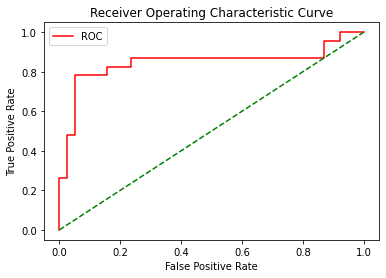

0.8455377574370709


In [ ]:
prob = log_model.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

2. KNN

In [ ]:
KNN_test = KNN.predict(X_test)
print(classification_report(y_test, KNN_test))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        38
           1       0.86      0.78      0.82        23

    accuracy                           0.87        61
   macro avg       0.87      0.85      0.86        61
weighted avg       0.87      0.87      0.87        61



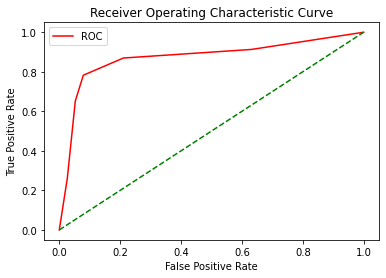

0.8707093821510297


In [ ]:
prob = KNN.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

In [ ]:
KNN_test_2 = KNN_2.predict(X_test)
print(classification_report(y_test, KNN_test_2))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        38
           1       0.90      0.78      0.84        23

    accuracy                           0.89        61
   macro avg       0.89      0.86      0.87        61
weighted avg       0.89      0.89      0.88        61



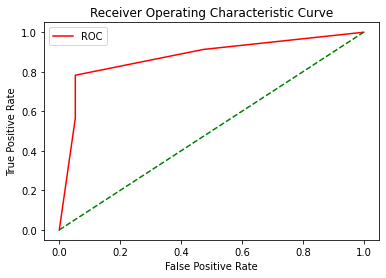

0.8752860411899314


In [ ]:
prob = KNN_2.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

3. SVM

In [ ]:
svc_test = svc.predict(X_test)
print(classification_report(y_test, svc_test))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        38
           1       0.82      0.78      0.80        23

    accuracy                           0.85        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61



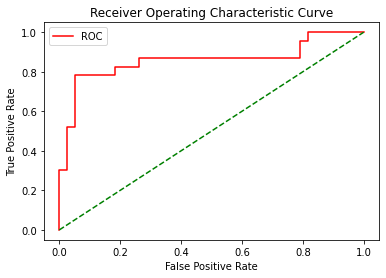

0.856979405034325


In [ ]:
prob = svc.decision_function(X_test)
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

In [ ]:
svc_test_rbf = svc_rbf.predict(X_test)
print(classification_report(y_test, svc_test_rbf))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        38
           1       0.75      0.78      0.77        23

    accuracy                           0.82        61
   macro avg       0.81      0.81      0.81        61
weighted avg       0.82      0.82      0.82        61



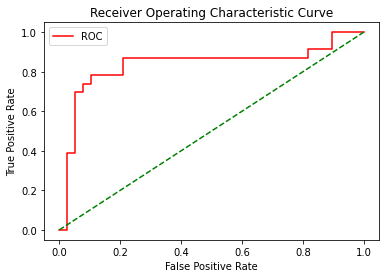

0.834096109839817


In [ ]:
prob = svc_rbf.decision_function(X_test)
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

In [ ]:
svc_test_poly = svc_poly.predict(X_test)
print(classification_report(y_test, svc_test_poly))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        38
           1       0.86      0.78      0.82        23

    accuracy                           0.87        61
   macro avg       0.87      0.85      0.86        61
weighted avg       0.87      0.87      0.87        61



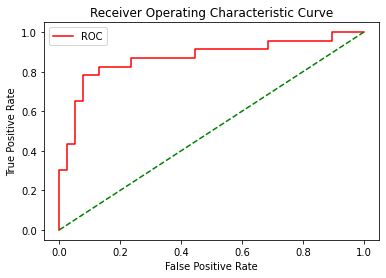

0.8707093821510298


In [ ]:
prob = svc_poly.decision_function(X_test)
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

4. Decision Tree Classifier

In [ ]:
dtc_test = dtc.predict(X_test)
print(classification_report(y_test, dtc_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        38
           1       0.71      0.74      0.72        23

    accuracy                           0.79        61
   macro avg       0.77      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



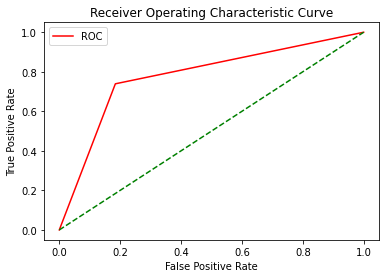

0.7774599542334095


In [ ]:
prob = dtc.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

5. Random Forest Classifier

In [ ]:
rfc_test = rfc.predict(X_test)
print(classification_report(y_test, rfc_test))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        38
           1       0.78      0.78      0.78        23

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



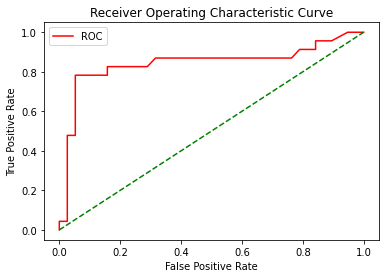

0.8421052631578948


In [ ]:
prob = rfc.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

6. XGBoost

In [ ]:
xgb_test = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_test))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        38
           1       0.78      0.78      0.78        23

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



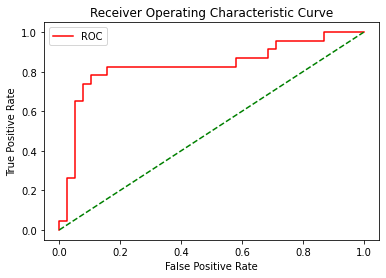

0.8318077803203662


In [ ]:
prob = xgb_model.predict_proba(X_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

7. Neural Network

In [ ]:
dnn_test = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, dnn_test))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        38
           1       0.78      0.78      0.78        23

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



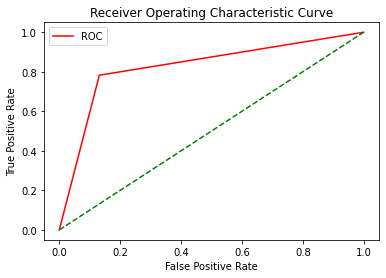

0.8255148741418764


In [ ]:
y_pred_dnn = dnn_test.ravel()
fper, tper, thresholds = roc_curve(y_test, y_pred_dnn)
plot_roc_curve(fper, tper)
print(auc(fper, tper))

각 모델 모두 classification_report, auc 값에서 모두 80% 정도의 성과를 보이며, roc curve는 좌측 상단으로 치우쳐져 있어서 올바른 방향으로 모델링되었다고 할 수 있겠다. 따라서 값 차이가 큰 폭으로 나지 않기에 어떤 모델이 더 적합하다고 결론내리는 것보다는 실제로 새로운 dataset에 모델들을 적용할 때 상황에 맞는 모델을 사용하여 평가하는 것이 바람직할 것이다.

Reference
- 파이썬 머신러닝 완벽 가이드(권철민 저, 위키북스, 2019)
- 핸즈온 머신러닝 2판(오렐리앙 제롱 저/박해선 역, 한빛미디어, 2020) 
- 실전활용! 텐서플로 딥러닝 프로젝트(루카 마사론 외, 위키북스, 2018)